# Web Scraping Reddit 
<img align="center" width="300" height="200" src="../image/reddit_logo.jpg" />

(Image provided from [link](https://www.slashgear.com/reddit-is-experiencing-another-outage-heres-what-we-know-18592169/))

## Problem Statement
---
When writing and publishing an article in the news, it is important to have great headlines to draw the reader's attention. As a small publisher, we want to emphasize on positivity of news all over the world. Our stories and headlines should be different and unique compared to other headlines. Our readers should feel the positivity we want to convey when they read our headlines. 

The problem we are trying to answer here is: **Are there any distinct keywords in titles, that would make someone perceive news as positive?**

Reddit is a network of communities based on people's interests. We are going to use the posts of `r/worldnews` and `r/positive_news` to analyze this problem. Titles of each Subreddit are being extracted and analyzed using classification models, Multinomial Naive Bayes and Logistic Regression. We will use key words in titles to predict whether the title are listed in `r/positive_news` or `r/worldnews`. Our evaluation metrics will be accuracy score. False positive/false negative in this case are equally bad. Therefore, accuracy is likely the best metric to use to measure success for our models.

## Executive Summary 
---
The first part of the project was to use web scraping to collect data from two Subreddits, `r/worldnews` and `r/positive_news`. By using a test case, we determined that the information we needed was located in the `title` of the posts. After pulling the data, the information was then saved in a new data frame. Punctuation and duplicates were then removed during data cleaning. Exploratory data analysis was then conducted by counting the word frequency to determine if additional cleaning or preprocessing was required. Our model was predicting, whether a title was from `r/positive_news` or not by using key words in the training data set. 

The following classification models were used to analyze our data:

- Multinomial Naive Bayes with CountVectorizer and TfidfVectorizer

- Logistic Regression with CountVectorizer and TfidfVectorizer

Additionally, _GridSearch_ and _Pipeline_ were used to find out the best parameters for these models. Accuracy score was then used to evaluate these models. Since in this case any misclassification is equally bad, accuracy score is the likely the best metric to evaluate these model.  We also further investigated our worst and best model to understand our incorrect predictions better by looking at coefficients as well as misclassification. Conclusions and results were then successfully obtained to answer our problem statement and a presentation was created and presented.

## Table of Contents
---

[1. Data Collection](#1.-Data-Collection)  
- [Test case](#Test-case)
- [Function for data collection](#Function-for-data-collection)  

[2. Data Cleaning](#2.-Data-Cleaning)    
- [First look](#First-look)
- [Remove punctuation](#Remove-punctuation)
- [Duplicates](#Duplicates)

[3. EDA](#3.-EDA)  
- [Preparations](#Preparations)
- [Stop words included](#Stop-words-included)
- [Stop words removed](#Stop-words-removed)
- [Bigram](#Bigram)

[4. Preprocessing](#4.-Preprocessing)
- [Numbers and Lemmatization](#Numbers-and-Lemmatization)
- [Preparation for Modeling](#Preparation-for-Modeling)

[5. Modeling](#5.-Modeling)
- [Baseline Model](#Baseline-Model)
- [Multinomial Naive Bayes Model](#Multinomial-Naive-Bayes-Model)
- [Logistic Regression Model](#Logistic-Regression-Model)
- [Summary of Model](#Summary-of-Model)

[6. Evaluation](#6.-Evaluation) 
- [Data frame of predictions](#Data-frame-of-predictions)
- [Deep Dive analysis](#Deep-Dive-analysis)
- [Summary of evaluation](#Summary-of-evaluation)

[7. Conclusion and Recommendations](#7.-Conclusion-and-Recommendations)  


## 1. Data Collection
---
We are going to scrape from the homepage `https://www.reddit.com` using requests library.   
The two Subreddits we are going to scrape are `r/worldnews` and `r/positive_news`. 

In this process, the first step is to create a test case, where we can test our requests on the homepage and see what kind of information are going to be relevant for us to answer our problem statement.
The second step in data collection is use a function to pull, collect, and save the data accordingly. 

#### Import packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas  as pd
import regex   as re
import seaborn as sns
import regex   as re
import numpy   as np

import matplotlib.pyplot as plt
%matplotlib inline 

import requests
import time 

from nltk.tokenize        import RegexpTokenizer
from nltk.stem            import WordNetLemmatizer
from nltk.stem.porter     import PorterStemmer

from sklearn.pipeline                   import Pipeline, FeatureUnion
from sklearn.model_selection            import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model               import LogisticRegression
from sklearn.feature_extraction.text    import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes                import MultinomialNB


#### Test case

Created url for API call

In [2]:
url_base = "https://www.reddit.com/r/worldnews.json"
user_agent = {"User-agent": 'agent'}      

Make a request 

In [3]:
res = requests.get(url_base,
                   headers = user_agent)

Request response code 

In [4]:
res.status_code

200

Since the response code is 200, it indicated that our request succeeded

In [5]:
json_data = res.json()

Our request is being saved in `json_data` as a dictionary and we can extract features from the dictionary

In [6]:
posts = []                                       #Created empty list 

#Iterating through each keys in dictionary
for keys in json_data['data']['children']:       
    
    post = {}                                       #Created empty dictionary 
    post['title'] = keys['data']['title']           #Extracting title
    post['subreddit'] = keys['data']['subreddit']   #Extracting which Subreddit it is
    post['text'] = keys['data']['selftext']         #Extracting text in the post 
    
    posts.append(post)                              #post dictionary is being in a list 

Creating a test data frame

In [7]:
pd.DataFrame(posts).head()

,title,subreddit,text
0,Arnold Schwarzenegger praises climate activist...,worldnews,
1,Kurds Confront Exiting U.S. Troops In Syria Wi...,worldnews,
2,Prince Andrew took part in orgy with nine girl...,worldnews,
3,Magic: The Gathering pro expresses support on ...,worldnews,
4,Hong Kong descends into chaos again as protest...,worldnews,


**Observation:** _According to the test case, we can see that the information we need is located in `title` of the post. In order to accelerate this process, we are going to use a function to make requests and save the information we pull into a dictionary. This will be very useful later when we are creating a data frame._

#### Function for data collection

This function makes requests on the Subreddit (input) and returns the information stored into a list

In [8]:
def pull_data(url, number=1):                               
    posts_list = []     #Final list 
    after = None        #'after' is defined as none as the first pull doesn't have 'after'
    user_agent = {"User-agent": 'agent'}
    url_base = "https://www.reddit.com/r/" + url + ".json"
    
    #Iterating through the range of speicified number 
    for pull_num in range(number):
        
        #Create a message to tell us which request number we're at
        print(f"Pull number: {pull_num+1}")
        
        #Using string concatenation, this is appended to the base URL
        if after == None:                          
              new_url = url_base 
        else: 
              new_url = url_base + "?after=" + after 

        # Step 1: Make request
        res = requests.get(url = new_url,
                           headers = user_agent)

        # Step 2: Extract data 
        if res.status_code == 200:
            json_data = res.json()     
            posts = []  

                #Extracting the information we need and append it to posts list
            for keys in json_data['data']['children']:
                post = {}
                post['subreddit'] = keys['data']['subreddit']
                post['title'] = keys['data']['title']
                posts.append(post)

            posts_list.extend(posts)   


        # Step 3: Update the after string for next loop
            after = json_data['data']['after']
            # 'after' = ID of the last post in this pull iteration
        else:
            print("We've run into an error. The status code is:", res.status_code)
            break

        # Create a brief pause so the API doesn't lock you out by mistaking you for a machine
        time.sleep(5)
    
    return posts_list

**Note**: _The following code for pulling data are being commented out so it doesn't run every time we restart our notebook and overrides the existing CSV file_

Pulling data from 1st Subreddit

In [9]:
#worldnews = pull_data('worldnews',40)

Pulling data from 2nd Subreddit

In [10]:
#pnew = pull_data('Positive_News',40)

Combining both data 

In [11]:
#worldnews.extend(pnew)

Creating Data frame

In [12]:
#df = pd.DataFrame(worldnews)

Saving to a Data frame

In [13]:
#df.to_csv("../data/subreddit.csv", index=False)

## 2. Data Cleaning 
---

#### First look

In [14]:
#Reading in our dataframe
df = pd.read_csv('../data/subreddit.csv')

In [15]:
df.head()

,subreddit,title
0,worldnews,‘South Park’ episode banned in China screened ...
1,worldnews,'Tip of the Iceberg': Prosecutors Allege Vast ...
2,worldnews,Prosecutors say Giuliani associates were tryin...
3,worldnews,Two Men Who Worked With Rudy Giuliani To Dig U...
4,worldnews,'South Park' declares 'F--- the Chinese govern...


Checking how many rows the data contains

In [16]:
df.shape

(1992, 2)

Checking distribution of class

We are checking that our classes (world news and positive news) have approximately equal amount of rows. So that later on when we are modeling, our classes are not unbalanced.

In [17]:
df['subreddit'].value_counts(normalize=True)

Positive_News    0.501506
worldnews        0.498494
Name: subreddit, dtype: float64

As we can see by the output, the classes are not unbalanced

#### Remove punctuation

We are going to "tokenize" our data. This basically means that our data is going to be split up into distinct chunks based on some pattern.  
During this process: 
- All string will be converted to lower case
- All punctuation will be removed
- All single letters will also be removed

In [18]:
clean_rows = []

#Iterating through each row in title
for rows in df['title']:
    
    #Instantiate Tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    
    #Run Tokenizer on each row and converting each row into lower case 
    rows_token = tokenizer.tokenize(rows.lower())
    
    #Elinimating single words
    rows_token = [words for words in rows_token if len(words) != 1]
    
    #Converting it back to a list
    clean = (" ".join(rows_token))
    
    #Saving cleaned rows into new list
    clean_rows.append(clean)

Adding new column with clean titles

In [19]:
df['title_clean'] = pd.Series(clean_rows)

In [20]:
df['title_clean'].head()

0    south park episode banned in china screened on...
1    tip of the iceberg prosecutors allege vast cri...
2    prosecutors say giuliani associates were tryin...
3    two men who worked with rudy giuliani to dig u...
4    south park declares the chinese government in ...
Name: title_clean, dtype: object

Now that we have just removed punctuation in the data set, we are going to check if there are duplicates in our data before we continue with exploratory data analysis.

#### Duplicates 

Checking for duplicate titles in both Subreddits.

In [21]:
df['title_clean'].duplicated().sum()

240

As we can see here with `.duplicated()` output, there are around 240 rows of duplicates in total and we are going to look into each Subreddit specifically to find out, where these duplicates are.

Duplicates in Subreddit `worldnews`

In [22]:
print(f"There are: {df['subreddit'][(df['title_clean'].duplicated()) & (df['subreddit'] == 'worldnews')].count()} duplicates in world news")

There are: 237 duplicates in world news


Duplicates in subreddit `Positive News`

In [23]:
print(f"There are: {df['subreddit'][(df['title_clean'].duplicated()) & (df['subreddit'] == 'Positive_News')].count()} duplicates in positive news")

There are: 3 duplicates in positive news


**Observation:** _All of these duplicate rows are going to be dropped from the data set_

In [24]:
#Dropping duplicates
df.drop_duplicates(subset=['title_clean'], inplace=True)

In [25]:
#Checking if the rows are dropped 
df.shape

(1752, 3)

This shows that 240 rows were dropped from our data

## 3. EDA 
--- 

Now that we have cleaned our data, we are going to dive into exploratory data analysis to see if we will be able to solve our problem statement.

#### Preparations

In the first part in our EDA, we are going to compare n-gram before and after removing stop words using a simple model, bag of words. N-gram is simply all combinations of adjacent words or letters of length n that we can find in our source text. 

- In our first function below we defined `n-gram` and if we want to remove `stop_words` or not. The model will then return the top `n` numbers of the most frequent words in our data set. 

- We are also creating two new variables. These variables will contain two new data frames, each ones with each Subreddit. 

- The second function below creates new data frames and combines them and the last function is to help us plot the new data frames we have created.

1. Function for top word frequency 

In [26]:
#Function for top count words (partial code from Stack Overflow)

def get_top_n_words(corpus, n=None, stop_words=None, ngram= (1,1)):
    
    #Instantiating and fitting Count Vectorizer with stop words 
    vec = CountVectorizer(stop_words = stop_words, ngram_range=ngram).fit(corpus)
    
    #Transforming vector
    bag_of_words = vec.transform(corpus)
    
    #Calculating the sum 
    sum_words = bag_of_words.sum(axis=0) 
    
    #Assigning sum count words (code found on Stack Overflow)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    #Sorting word frequencies (code found on Stack Overflow)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    #Returning only top n numbers 
    return words_freq[:n]

2. Assigning two new data frames 

In [27]:
#Rows that only contain world news
worldnews = df[ df['subreddit'] == 'worldnews']

In [28]:
#Rows that only contain positive news
pos_news = df[df['subreddit'] == 'Positive_News' ]

3. Function to create new Data frame and combine it 

In [29]:
def save_df(df_1, df_2):
    
    # Saving as a new Data frame r/worldnews
    df_world = pd.DataFrame(df_1, columns = ['reviewtext' , 'r/worldnews'])  

    # Saving as a new Data frame r/positive_news
    df_pos = pd.DataFrame(df_2, columns = ['reviewtext' , 'r/positive_news'] )

     # Merging two new data frames together
    new_df = df_world.merge(df_pos, on='reviewtext')     
    
    return new_df

4. Function to plot multiple plots

In [30]:
def plot_barh(list_1,list_2,figsize=(15,6), title_fontsize=20, xlabel_fontsize=15, ytickslabel_fontsize=12):

    #Creating new data frames
    df_1 = pd.DataFrame(list_1, columns= ['reviewtext' , 'worldnews'])
    df_2 = pd.DataFrame(list_2, columns = ['reviewtext' , 'positive news'] )

    #Adding subplots
    fig, ax = plt.subplots(ncols=2, figsize=figsize) 

    #Worldnews plot
    sns.barplot(x ='worldnews', y= 'reviewtext', data=df_1, ax=ax[0], palette=("Blues_r"))
    ax[0].set_title("Top 20 r/worldnews",fontsize= title_fontsize)
    ax[0].set_ylabel("")
    ax[0].set_xlabel("Count of words", fontsize=xlabel_fontsize)
    ax[0].set_yticklabels(labels=df_1['reviewtext'],fontsize=ytickslabel_fontsize)


    #Positive news plot
    sns.barplot(x ='positive news', y= 'reviewtext', data=df_2, ax=ax[1], palette=("BuGn_r"))
    ax[1].set_title("Top 20 r/positive_news",fontsize= title_fontsize)
    ax[1].set_ylabel("")
    ax[1].set_xlabel("Count of words", fontsize=xlabel_fontsize)
    ax[1].set_yticklabels(labels=df_2['reviewtext'],fontsize=ytickslabel_fontsize)

    plt.tight_layout
    
    return

#### Stop words included
We are going to analyze the text with stop words included using function to get top count of words in each Subreddit.

In [31]:
#Extracting common wolrds in Worldnews
common_words_world = get_top_n_words(worldnews['title_clean'], 20)

#Extracting common wolrds in positive news
common_words_pos= get_top_n_words(pos_news['title_clean'], 20)

Saving into a new data frame and merging it together on "words" that are common in both data frames using our function `save_df`

In [32]:
df_new = save_df(common_words_world,common_words_pos)

Plotting the two new data frames into a Horizontal Barplot using function `plot_barh`

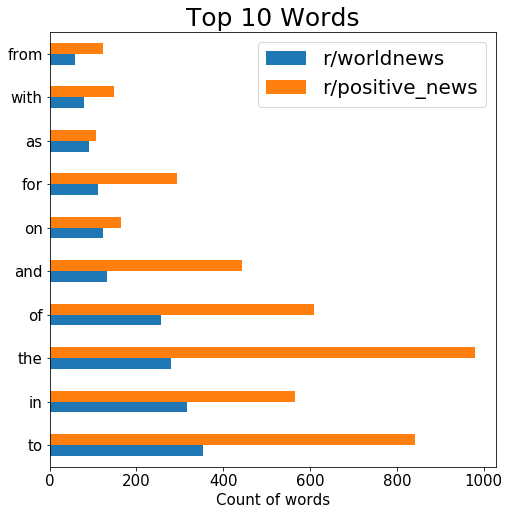

In [33]:
#Plotting Horizontal Barchart
ax = df_new.plot(kind='barh', x='reviewtext', fontsize=15,figsize=(8,8))

#Set title and size
ax.set_title(label="Top 10 Words",fontsize=25)    

#Set size of legend
ax.legend(fontsize=20)     

#Set axis label 
ax.set_xlabel("Count of words", fontsize=15)
ax.set_ylabel("");          

plt.savefig('../image/stopwords')

**Observation**: _As we can see in this graph, the most common words in both subreddits are stop-words. 
This is **not** going to be helpful in further analysis, because we want to find different key words in each subreddit. Therefore we need to remove stop-words in order to analyze the differences between these two subreddits._

#### Stop words removed

Using function to get top count of words in each Subreddit and removing stop-words

In [34]:
#Extracting common wolrds in Worldnews
common_words_world = get_top_n_words(worldnews['title_clean'], 20, stop_words='english')

#Extracting common wolrds in positive news
common_words_pos = get_top_n_words(pos_news['title_clean'], 20, stop_words='english')

Plotting both Subreddits after removing stop-words

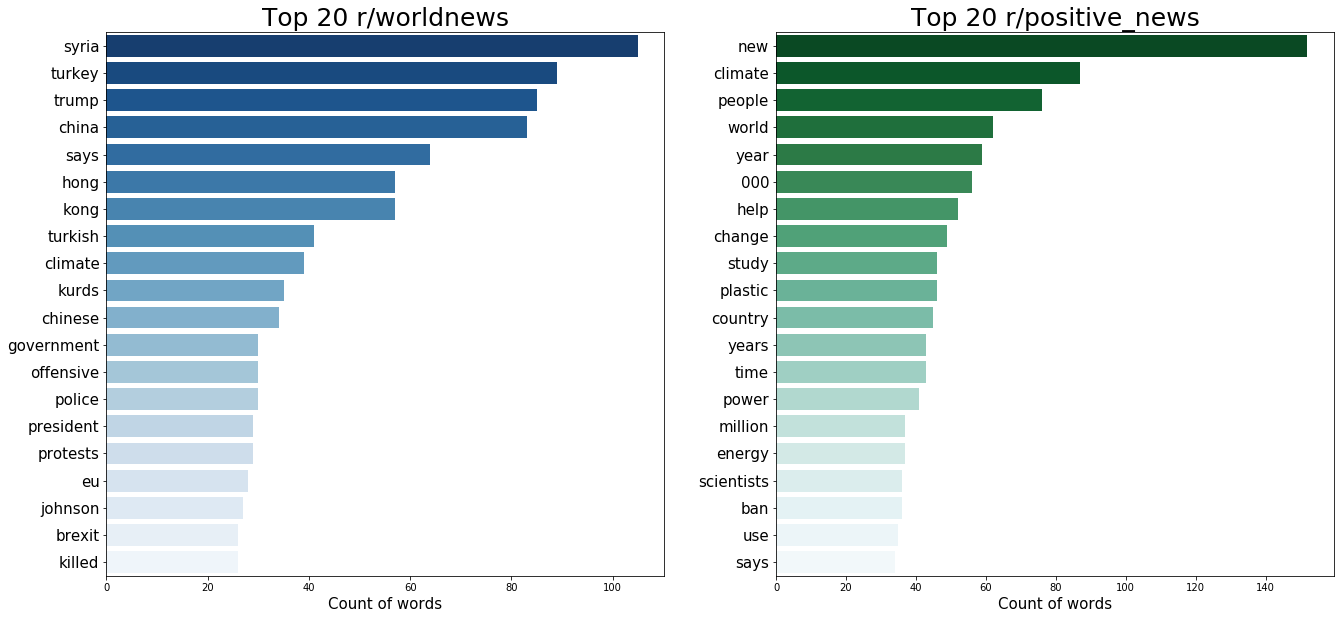

In [35]:
#Plotting using function above
plot_barh(common_words_world, common_words_pos, figsize=(22,10), ytickslabel_fontsize=15, title_fontsize=25)

#Saving plot
plt.savefig('../image/no_stop_words')

**Observation:** _Bag of words model is simplified representation of raw data. It discards grammar, order and structure in the text and only tracks for occurrences. One of the advantages is that it is an efficient model. However, since it discards grammar, order, structure and context, we might lose a decent amount of information. As we can see here in the graph, some of the words do not make sense (like 000) or they occur twice such as years and year. In this case it would make sense to look further into 2 n-gram range of words. Additional cleaning such as stemming words and removing numbers will be required in further processing._

#### Bigram

Using function to get top count of words in each subreddits, removing stop-words and 2 n-gram range

In [36]:
#Extracting common wolrds in Worldnews
common_words_world = get_top_n_words(worldnews['title_clean'], 20, stop_words='english', ngram=(2,2))

#Extracting common wolrds in positive news
common_words_pos = get_top_n_words(pos_news['title_clean'], 20, stop_words='english', ngram=(2,2))

Plotting results

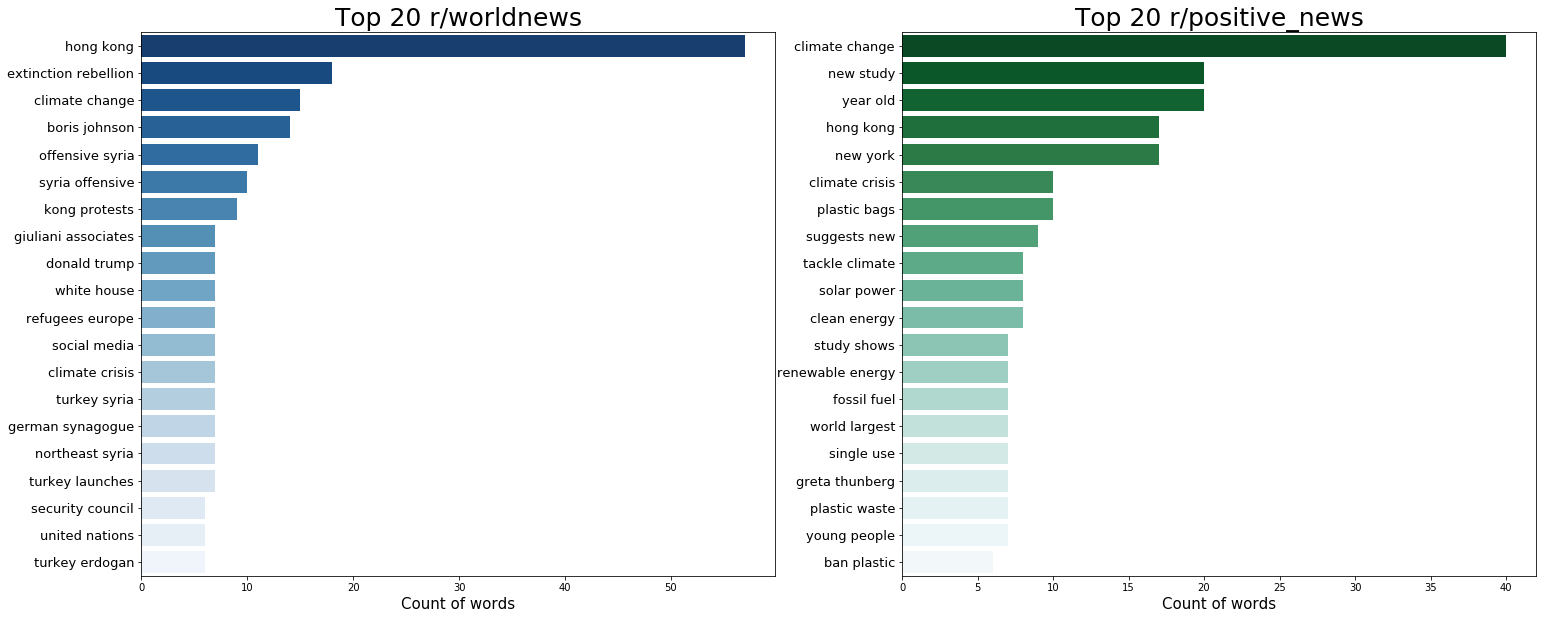

In [37]:
#Plotting using function above
plot_barh(common_words_world, common_words_pos, figsize=(25,10), ytickslabel_fontsize=13, title_fontsize=25)

#Saving plot
plt.savefig('../image/2ngram')

**Observation:** _In our 2 n-gram plot, we can see that there are some words that are distinct between these titles. For example in `r/worldnews` we can see a lot of words about politics and `r/positive_news`, on the other hand, has more words about the environment. These features will most likely be useful when it comes to modeling and answering our problem statement._

## 4. Preprocessing
---
Before we get into Modeling, we are going to do additional preprocessing with our data.
1. Step: We need to remove numbers in our data as EDA has shown that they are not significant key features in titles.
2. Step: We need to lemmatize our data set.(Lemmatization is the process of converting a word to its base form.)
3. Step: For our predictions we need to convert the column `subreddit` into a binary outcome, where `r/positive_news` = 1 and `r/worldnews` = 0 
4. Step: Our data needs to split into a training and testing set

#### Numbers and Lemmatization

In [38]:
#Instantiating Lemmatizer
lemmatizer = WordNetLemmatizer()

clean_words = []

#Iterating through each row
for rows in df['title_clean']:
    
    #Removing numbers
    letters_only = re.sub("[\d+]", "",rows)
    
    #Splitting words
    letters_only = letters_only.split()
    
    #Lemmatize words
    words = [lemmatizer.lemmatize(token) for token in letters_only]
    
    #Joining the words back into one string separated by space, 
    clean_word = (" ".join(words))
    
    #Saving it into a list
    clean_words.append(clean_word)

In [39]:
#Saving it back to Data frame
df['title_clean'] = clean_words

#### Preparation for Modeling 

Changing `r/worldnews` to 0 and `r/positive_news` to 1


In [40]:
df['subreddit_vec'] = df['subreddit'].map({'worldnews':0, 'Positive_News':1})

Looking at class distribution 

In [41]:
df['subreddit_vec'].value_counts(normalize=True)

1    0.568493
0    0.431507
Name: subreddit_vec, dtype: float64

**Observation**: _Classes are slightly unbalanced at 56.84\%. Y variable needs to be stratified when splitting our data_

Assigning variables 

In [42]:
X = df['title_clean']
y = df['subreddit_vec']

Train/Test split data 

We are splitting our data set into a 80/20 training and testing ratio.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify= y, test_size = 0.2)

## 5. Modeling
---
Since this problem is a binary outcome, we are going to use a classification model to predict our target and because our titles are text, we have to transform our unstructured text data into a numeric `X` matrix using two different vectorizers, `CountVectorizer` and `TfidfVectorizer` in order to predict with our classification model.

We are going try out the following models below with `GridSearch` and `Pipeline` in order to find the best model and best hyperparameter for the individual model. 

- Multinomial Naive Bayes Model with `CountVectorizer` and `TfidfVectorizer`

- Logistic Regression Model with `CountVectorizer` and `TfidfVectorizer`

#### Baseline Model 

In [44]:
print(f"Baseline model for training: {np.round(y_train.value_counts(normalize=True)[1],3)}")

Baseline model for training: 0.568


In [45]:
print(f"Baseline model for testing: {np.round(y_test.value_counts(normalize=True)[1],3)}")

Baseline model for testing: 0.57


**Observation:** _This is our base line model. In other words, given any post, we would predict that it belongs to `r/positive_news` every time with a base accuracy of 57%._

#### Multinomial Naive Bayes Model

GridSearch with 
- Vectorizer: `TfIdfVectorizer` and `CountVectorizer`
- Estimator: `Multinomial Naive Bayes`

In [46]:
#Defining Pipeline 
pipe = Pipeline([
    ('feats', FeatureUnion([
        ('tvec', TfidfVectorizer()),    #Vectorizer
        ('cvec', CountVectorizer()),    #Vectorizer
    ])),
    ('nb' , MultinomialNB())])


#Defining parameters for GridsearchCV 
pipe_params = [{
    'feats__tvec__max_features' : [3000,5000],
    'feats__tvec__ngram_range' : [(1,1),(1,2)],
    'feats__tvec__stop_words' : ['english'],
    'feats__cvec__max_features' : [3000,5000],
    'feats__cvec__ngram_range' : [(1,1),(1,2)],
    'feats__cvec__stop_words' : ['english']
}]

#Performing Grid Search
gs = GridSearchCV(pipe,        
                 param_grid=pipe_params,
                 cv = 5,
                 scoring = 'accuracy')

#Fitting Gridsearch
gs.fit(X_train, y_train);

In [47]:
#Printing best parameters
print("The best parameters for each model are:")
gs.best_params_

The best parameters for each model are:


{'feats__cvec__max_features': 5000,
 'feats__cvec__ngram_range': (1, 1),
 'feats__cvec__stop_words': 'english',
 'feats__tvec__max_features': 5000,
 'feats__tvec__ngram_range': (1, 1),
 'feats__tvec__stop_words': 'english'}

Calculating accuracy score for the best parameter for each vectorizer in MB Naive Bayes model

For `TfidfVectorizer`

In [48]:
#Assigning best parameter
best_tvec_mb = gs.best_estimator_.steps[0][1].transformer_list[0][1]

#Fitting and Transforming 
X_train_tvec_mb = best_tvec_mb.fit_transform(X_train)
X_test_tvec_mb = best_tvec_mb.transform(X_test)

#Instantiate Model
mb = MultinomialNB()

#Fitting
mb.fit(X_train_tvec_mb, y_train)

#Printing Score
print(f"Best training score for TfidfVectorizer: {np.round(mb.score(X_train_tvec_mb,y_train),3)}")
print(f"Best testing score for TfidfVectorizer: {np.round(mb.score(X_test_tvec_mb,y_test),3)}")

Best training score for TfidfVectorizer: 0.968
Best testing score for TfidfVectorizer: 0.866


For `CountVectorizer`

In [49]:
#Assigning best parameter
best_cvec_mb = gs.best_estimator_.steps[0][1].transformer_list[1][1]

#Fitting and Transforming 
X_train_cvec_mb = best_cvec_mb.fit_transform(X_train)
X_test_cvec_mb = best_cvec_mb.transform(X_test)

#Fitting
mb.fit(X_train_cvec_mb, y_train)

#Printing Score
print(f"Best training score for CountVectorizer: {np.round(mb.score(X_train_cvec_mb,y_train),3)}")
print(f"Best testing score for CountVectorizer: {np.round(mb.score(X_test_cvec_mb,y_test),3)}")

Best training score for CountVectorizer: 0.979
Best testing score for CountVectorizer: 0.863


#### Logistic Regression Model

GridSearch with: 
- Vectorizer: `TfIdfVectorizer` and `CountVectorizer`
- Estimator: `Logistic Regression`

In [50]:
#Defining Pipeline 
pipe = Pipeline([
    ('feats', FeatureUnion([
        ('tvec', TfidfVectorizer()),    #Vectorizer
        ('cvec', CountVectorizer()),    #Vectorizer
    ])),
    ('lg' , LogisticRegression())])


#Defining parameters for GridsearchCV 
pipe_params = [{
    'feats__tvec__max_features' : [3000,5000],
    'feats__tvec__ngram_range' : [(1,1),(1,2)],
    'feats__tvec__stop_words' : ['english'],
    'feats__cvec__max_features' : [3000,5000],
    'feats__cvec__ngram_range' : [(1,1),(1,2)],
    'feats__cvec__stop_words' : ['english']
}]

#Performing Grid Search
gs = GridSearchCV(pipe,        
                 param_grid=pipe_params,
                 cv = 5,
                 scoring = 'accuracy')

#Fitting Gridsearch
gs.fit(X_train, y_train);

#Printing best parameters
print("The best parameters for each model are:")
gs.best_params_

The best parameters for each model are:


{'feats__cvec__max_features': 5000,
 'feats__cvec__ngram_range': (1, 2),
 'feats__cvec__stop_words': 'english',
 'feats__tvec__max_features': 3000,
 'feats__tvec__ngram_range': (1, 1),
 'feats__tvec__stop_words': 'english'}

Calculating accuracy score for the best parameter for each vectorizer in Logistic Regression model

For `TfidfVectorizer`

In [51]:
#Assigning best parameter
best_tvec_lg = gs.best_estimator_.steps[0][1].transformer_list[0][1]

#Fitting and Transforming 
X_train_tvec_lg = best_tvec_lg.fit_transform(X_train)
X_test_tvec_lg = best_tvec_lg.transform(X_test)

#Instantiate Model
lg = LogisticRegression()

#Fitting
lg.fit(X_train_tvec_lg, y_train)

#Printing Score
print(f"Best training score for TfidfVectorizer: {np.round(lg.score(X_train_tvec_lg,y_train),3)}")
print(f"Best testing score for TfidfVectorizer: {np.round(lg.score(X_test_tvec_lg,y_test),3)}")

Best training score for TfidfVectorizer: 0.929
Best testing score for TfidfVectorizer: 0.835


For `CountVectorizer`

In [52]:
#Assigning best parameter
best_cvec_lg = gs.best_estimator_.steps[0][1].transformer_list[1][1]

#Fitting and Transforming 
X_train_cvec_lg = best_cvec_lg.fit_transform(X_train)
X_test_cvec_lg = best_cvec_lg.transform(X_test)

#Fitting
lg.fit(X_train_cvec_lg, y_train)

#Printing Score
print(f"Best training score for CountVectorizer: {np.round(lg.score(X_train_cvec_lg,y_train),3)}")
print(f"Best testing score for CountVectorizer: {np.round(lg.score(X_test_cvec_lg,y_test),3)}")

Best training score for CountVectorizer: 0.996
Best testing score for CountVectorizer: 0.866


#### Summary of model

_All scores here are accuracy scores._

Model|Vectorizer|Train Score|Test Score|
---|---|---|---|
Baseline||0.568|0.570
**MB Naive Bayes**| **Tfidf**|**0.968**|**0.866**
MB Naive Bayes| Count|0.979|0.863
Logistic Regression| Tfidf|0.926|0.835
Logistic Regression| Count|0.996|0.866



Comparing all these models we can see that our best model is Multinomial Naive Bayes Model with `TfidfVectorizer` with an accuracy score of 97% in training and accuracy score of 87% in testing. The training accuracy scores are very high for each of the models, but all of the models did not do well in unfamiliar environments. However, all our models performed much better than the baseline model. `TfidfVectorizer` did better on both classification models than `CountVectorizer`. 
- One downside of `CountVectorizer` is that it creates a vector for each token and counts up the number of occurrences of each token in each document. Words in 99% of documents or words occurring in only one document might not be very informative when it comes to our predictions. This can also be the reason why `TfidfVectorizer` performed better as common words are penalized and rare words have more influence.

- Both classification models performed well, but MB Naive Bayes model was the one that has the least amount of errors compared to logistic regression model. Since Naive Bayes assumes that all words are independent of each other, it is not sensitive about outliers. Logistic Regression on the other hand is sensitive to outliers, which is shown due to high variance in errors in the results.

In conclusion, all of the models are slightly over-fitted. However, we are going to further investigate our results with our worse model and best model.

## 6. Evaluation

#### Data frame of predictions

Our _worst_ model was Logistic Regression with `CountVectorizer` and we are going to create a data frame. This will help us to look at the coeefficient of the model.

In [53]:
pd.DataFrame(X_train_cvec_lg.todense(), columns=best_cvec_lg.get_feature_names()).head()

,ab,abandon,abandoned,abandoning,ability,able,aboard,abortion,abortion ban,abortion clinic,...,ypg,ypg pkk,zealand,zelenskiy,zero,zero carbon,zero emission,zero waste,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Looking at coefficient of our model

In [54]:
coef_df = pd.DataFrame({'coef': lg.coef_[0],
                        'term': best_cvec_lg.get_feature_names()
                       })

Finding the top 20 coefficient by sorting and making a new data frame `coef`

In [55]:
low_coef = coef_df.sort_values(by='coef').head(10)
high_coef = coef_df.sort_values(by='coef', ascending=False).head(10)
coef = pd.concat([low_coef,high_coef])

Plotting `coef` data frame

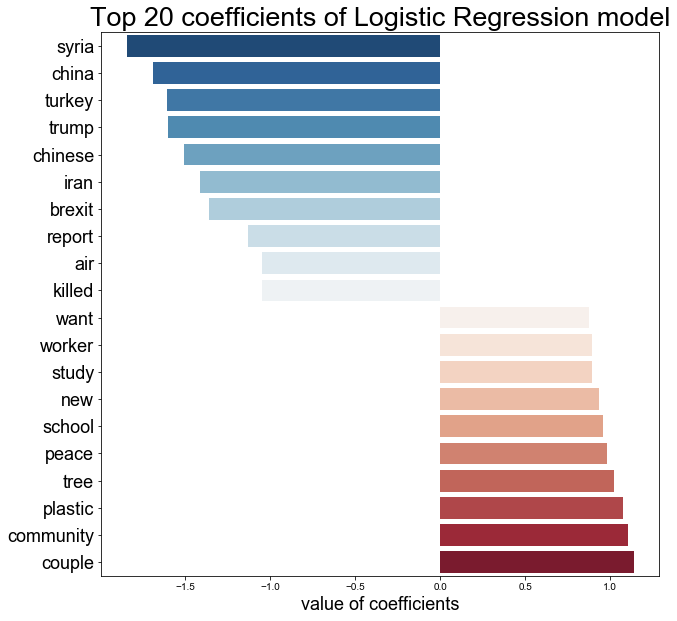

In [56]:
#Plotting barplot
plt.figure(figsize=(10,10))
ax = sns.barplot(x = 'coef', y='term',data=coef.sort_values(by='coef'), palette=('RdBu_r'))

#Set title and size
ax.set_title(label="Top 20 coefficients of Logistic Regression model",fontsize=27)    

#Set axis label and size
ax.set_xlabel("value of coefficients", fontsize=18)
ax.set_ylabel("")
ax.set_yticklabels(labels=coef['term'], fontsize=18)

sns.set(font_scale=1.4);

**Observation:** _As we can see here at the coefficients most words that have a negative coefficient have an ongoing theme about countries such as Syria, Turkey or China and government such as Brexit or Trump. On the hand, we can see that positive words are out Peace, tree or the environment. The same observation was observed in during EDA._

Our _best_ model was MB Naive Bayes Model with `TfidfVectorizer`. We are going to create a new data frame with our best model

In [57]:
#Predictions
train_preds = mb.predict(X_train_tvec_mb)
test_preds = mb.predict(X_test_tvec_mb)

#Data frame for predictions for our training set 
pred_df_train = pd.DataFrame({
    'title':X_train,
    'actual':y_train,
    'prediction':train_preds})

#Data frame for predictions for our testing set 
pred_df_test = pd.DataFrame({
    'title': X_test,
    'actual': y_test,
    'prediction': test_preds})

In [58]:
#Looking into prediction data frame from training set 
pred_df_train.head()

,title,actual,prediction
696,government plan km long great green wall of india,0,1
345,extinction rebellion protester climb on plane ...,0,0
194,thai cafe forced to track customer wifi use sp...,0,0
1571,ireland to unveil bold plan to tackle climate ...,1,1
1348,in the th hour court halt copper mine from des...,1,1


In [59]:
#Looking into prediction data frame from testing set 
pred_df_test.head()

,title,actual,prediction
1973,ramadan understanding it history and tradition...,1,1
1905,africa ethiopia ghana malawi rwanda and south ...,1,1
587,nobel physic prize ground breaking win for pla...,0,0
159,france britain germany to condemn turkish offe...,0,0
1746,thousand of people have been encouraged by mom...,1,1


Filtering through prediction data frames to find wrong predictions in each data set

In [60]:
wrong_preds_train = pred_df_train[pred_df_train['actual'] != pred_df_train['prediction']]
wrong_preds_test = pred_df_test[pred_df_test['actual'] != pred_df_test['prediction']]

In [61]:
print(f"There are a total of {wrong_preds_train.shape[0]} rows of wrong predictions in {len(pred_df_train)} rows of training set")
print(f"There are a total of {wrong_preds_test.shape[0]} rows of wrong predictions in {len(pred_df_test)} rows of testing set")

There are a total of 26 rows of wrong predictions in 1401 rows of training set
There are a total of 45 rows of wrong predictions in 351 rows of testing set


#### Deep Dive analysis

Example of False Positive prediction 

In [64]:
print(f"Original title from r/worldnews: {df.loc[462,'title']}")
print(f"Prediction title to r/positive_news: {pred_df_train.loc[462,'title']}")

Original title from r/worldnews: Protien technology's to collapse animal farming within 10 years.
Prediction title to r/positive_news: protien technology to collapse animal farming within year


Example for False Negative prediction

In [63]:
print(f"Original title from r/positive_news: {df.loc[1681,'title']}")
print(f"Prediction title to r/worldnews: {pred_df_train.loc[1681,'title']}")

Original title from r/positive_news: Sudan protest leaders call for civil disobedience
Prediction title to r/worldnews: sudan protest leader call for civil disobedience


#### Summary of evaluation

In conclusion, there are 26 rows of wrong predictions out a total of 1400 from the training set and 45 rows out of a total of 350 from the testing set in our best model. As observed with our coefficient of Logistic Regression model, we can conclude that positive words are about the environment, community, people and mostly not about countries and politics.

However, due to noise within our data, we saw the predictions in our False positive example, that it was predicting positive and not negative. We most likely would have also predicted that the title is from `r/positive_news` because it's about animal farming and during our EDA and coefficients we saw environmental features in our predictions for `r/positive_news`. The same goes for false negative examples, where the title was about protest and civil disobedience and during analysis we discovered key words about politics tend to be more in `r/worldnews`. 

One limitation with Logistic Regression model is that it requires that each data point be independent of all other data points. This might not be the case here with our data. This is probably why our MB Naive Bayes model performed better than Logistic Regression as it already assumes that all data are independent of each other. However, one advantage of our Logictic Regression model is that it is very easy to interpret like shown in the coefficient plot.

Overall, our model did well in predicting in which Subreddit the title belonged. Even with the errors, we can see that even a human would have mistaken some of the posts._

## 7. Conclusion and Recommendations
---

In conclusion, our best predictive model was MB Naive Bayes model, where we predicted an accuracy score of 95% in training and accuracy score 87% in testing. Surprisingly, our best model used n-gram range of 1, which means that it predicted our outcome only by using single words. 

- One disadvantage of the Naive Bayes model is that it assumes that all the words are independent of each other. Therefore, grammar, order and structure in the text are lost with this model. However, sometimes in titles, context of the whole corpus plays a big role in determining how the titles are perceived by humans. This is a big downside of the model. 
- On the other hand, the model is very efficient and great with many features. In this case we used 3000 features in our model. It outperformed our logistic regression models, because it is not sensitive to outliers due to variable independence . 

During the entire analysis of predicting our `r/worldnews` and `r/positive_news`, we saw that world news titles have the trend of talking about politics and government in many different countries, whereas positive news had a lot of information about the environment. Therefore to answer our problem, we can conclude that there are possible keywords in headlines that would make someone perceive news as positive. If we want to have our readers perceive news as positive, we should write more about the environment instead of politics and government is our recommendation. 

The next step would be improving our models by including more diverse data to see if there are more features, not just environment, that would give us better recommendations. Including more data about others topics might diversify our results even further. During modeling n-gram range 2 showed in EDA that there was significant differences between the titles, however, our model was not able to predict great results based on that. With this in mind, by adding more data, we might be able to tune our parameters better such as lowering maximum features and increasing n-gram range to add more context, structure and order to our prediction model. Additionally, another way to improve our model is using more a advanced classification model, where we won't lose the context of the corpus when analyzing the data.